
# Getting started

## Command line interface
You can analyse a dataset used the command line interface as follows
```
python -m mps_motion PointH4A_ChannelBF_VC_Seq0018.nd2
```
Here `PointH4A_ChannelBF_VC_Seq0018.nd2` is an example file containing cardiac cell data.
Note that in order to read these data you need to also install the `mps` package.
To see all available options for the cli you can do
```
python -m mps_motion --help
```

## Computing displacement, velocity and strain

First we need to import the required libraries

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt # For plotting
import mps # Package to load data
import mps_motion # Package for motion analysis

Next, let us download to sample data. There is one available dataset here, but you should swap out the paths here to the path to your own data.

In [2]:
path = Path("data.nd2")
if not path.is_file():
    mps_motion.utils.download_demo_data(path)

Now we will read this file using the `cardiac-mps` package and print some info about the file

In [3]:
# Load raw data from Nikon images
data = mps.MPS(path)
print(data.info) # {'num_frames': 267, 'dt': 11.92, 'time_unit': 'ms',
# 'um_per_pixel': 0.325, 'size_x': 2044, 'size_y': 1174}b

2022-10-02 16:19:16,473 [37527] INFO     mps.load: Load nd2 file /Users/finsberg/local/src/mps_motion_tracking/docs/data.nd2
2022-10-02 16:19:17,464 [37527] INFO     mps.load: Loaded 267 frames in 0.99 seconds


{'num_frames': 267, 'dt': 11.926342039179985, 'time_unit': 'ms', 'um_per_pixel': 0.325, 'size_x': 2044, 'size_y': 1174}


Now, we will create an optical flow object which is the object we use to run the motion tracking software. Here we have chosen the *Farneback* optical flow algorithm and we use the first frame as reference. 

In [4]:
opt_flow = mps_motion.OpticalFlow(data, flow_algorithm="farneback", reference_frame=0)

To list available optical flow algorithms you can use

In [5]:
mps_motion.list_optical_flow_algorithm()

['farneback', 'dualtvl1', 'lucas_kanade', 'block_matching']

We can now run the optical flow algorithm to extract the displacements. We will first perform a downsampling of the data to a scalar of 0.4 (i.e 40% of the original size) to make the problem less computational expensive

In [6]:
u = opt_flow.get_displacements(scale=0.4)
print(u) # VectorFrameSequence((817, 469, 267, 2), dx=0.8125, scale=0.4)

2022-10-02 16:19:18,556 [37527] INFO     mps_motion.scaling: Resize frames


[########################################] | 100% Completed | 1.11 sms
[########################################] | 100% Completed | 108.60 ms


2022-10-02 16:19:20,313 [37527] INFO     mps_motion.scaling: Done resizing
2022-10-02 16:19:20,324 [37527] INFO     mps_motion.farneback: Get displacements using Farneback's algorithm


[########################################] | 100% Completed | 1.69 sms


2022-10-02 16:19:22,837 [37527] INFO     mps_motion.farneback: Done running Farneback's algorithm


VectorFrameSequence((817, 469, 267, 2), dx=0.8125, scale=0.4)


We see that the object we get back is a `VectorFrameSequence`. This is a special object that represents a vector field for each image in the sequence of images, and we see that is has dimension (number of pixels in x $\times$ number of pixels in x $\times$ number of time steps $\times$ 2) where the final two dimensions are the $x-$ and $y-$ component of the vectors. If we take the norm of this `VectorFrameSequence` we get a `FrameSequence`

In [7]:
u_norm = u.norm()
print(u_norm) # FrameSequence((817, 469, 267), dx=0.8125, scale=0.4)

FrameSequence((817, 469, 267), dx=0.8125, scale=0.4)


Note that the norm here represents the norm at each pixel in the stack of images. To get a proper trace we can for example compute the mean across all the pixels. Note that the arrays we work with here are lazy evaluated (using [`dask` arrays](https://docs.dask.org/en/stable/array.html)) so we need to also call the `.compute` method to get some actual results. 

In [8]:
# Compute mean of the norm of all pixels
u_norm_mean = u_norm.mean().compute()

Let us also plot the trace

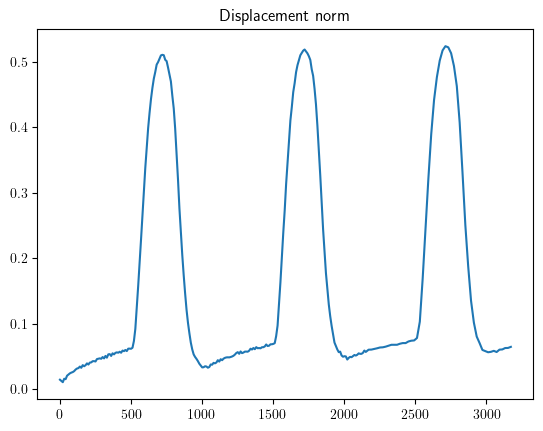

In [9]:
fig, ax = plt.subplots()
ax.plot(data.time_stamps, u_norm_mean)
ax.set_title("Displacement norm")
plt.show()

We can also create a movie with the displacment vectors. Since we now have scaled the displacement we would also need to send in a scale data set for the background images

In [17]:
scaled_data = mps_motion.scaling.resize_data(data, scale=u.scale)
movie_path = "motion.mp4"
mps_motion.visu.quiver_video(scaled_data, u, movie_path, step=48, vector_scale=10)

2022-10-02 16:25:19,225 [37527] INFO     mps_motion.scaling: Resize frames


[########################################] | 100% Completed | 1.13 sms
[########################################] | 100% Completed | 107.01 ms


2022-10-02 16:25:20,995 [37527] INFO     mps_motion.scaling: Done resizing
Create quiver video at flow.mp4: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 267/267 [00:02<00:00, 102.84it/s]
2022-10-02 16:25:24,329 [37527] WARNING  imageio_ffmpeg: IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (816, 468) to (816, 480) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Now we can load the movie

In [18]:
from IPython.display import Video
Video(movie_path)

From the displacement we can also compute several other mechanics features, such as the velocity and strain. This is most conveniently handled by first creating a `Mechanics` object

In [10]:
mech = mps_motion.Mechanics(u=u, t=data.time_stamps)

For example we can compute the velocity using a spacing of 1

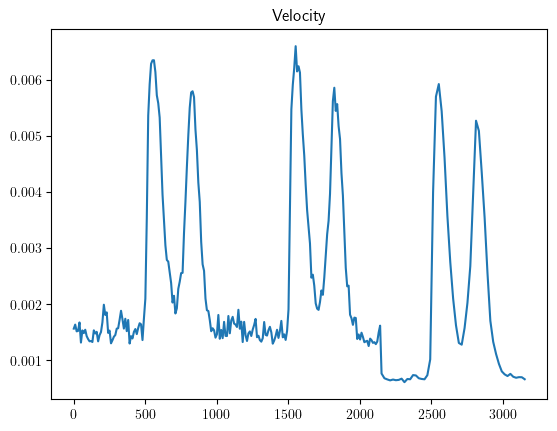

In [11]:
spacing = 1
v = mech.velocity(spacing=spacing)
v_norm_mean = v.norm().mean()
fig, ax = plt.subplots()
ax.plot(data.time_stamps[:-spacing], v_norm_mean)
ax.set_title("Velocity")
plt.show()

or we can compute the mean value of the $x$-component of the  Green-Lagrange strain tensor

2022-10-02 16:19:24,865 [37527] INFO     mps_motion.mechanics: Compute gradient using spline interpolation
2022-10-02 16:19:25,053 [37527] INFO     mps_motion.mechanics: Compute interpolant Ux


[########################################] | 100% Completed | 1.16 sms


2022-10-02 16:19:26,233 [37527] INFO     mps_motion.mechanics: Compute interpolant Uy


[########################################] | 100% Completed | 1.17 sms


2022-10-02 16:19:27,458 [37527] INFO     mps_motion.mechanics: Compute dudx


[########################################] | 100% Completed | 314.79 ms


2022-10-02 16:19:28,162 [37527] INFO     mps_motion.mechanics: Compute dudy


[########################################] | 100% Completed | 318.86 ms


2022-10-02 16:19:28,866 [37527] INFO     mps_motion.mechanics: Compute dvdx


[########################################] | 100% Completed | 246.46 ms


2022-10-02 16:19:29,490 [37527] INFO     mps_motion.mechanics: Compute dvdy


[########################################] | 100% Completed | 314.55 ms


2022-10-02 16:19:30,222 [37527] INFO     mps_motion.mechanics: Stack arrays
2022-10-02 16:19:30,226 [37527] INFO     mps_motion.mechanics: Done computing gradient


TensorFrameSequence((817, 469, 267, 2, 2), dx=0.8125, scale=0.4)


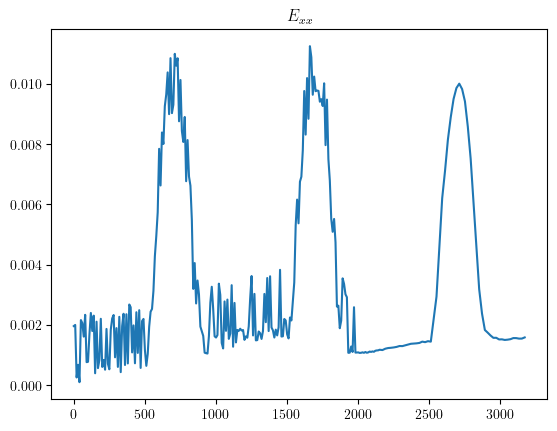

In [12]:
# Green-Lagrange strain
print(mech.E) # TensorFrameSequence((817, 469, 267, 2, 2), dx=0.8125, scale=0.4)

# Plot the X-component of the Green-Lagrange strain
fig, ax = plt.subplots()
ax.plot(data.time_stamps, mech.E.x.mean().compute())
ax.set_title("$E_{xx}$")
plt.show()